# TD 8 : Interface avec Jupyter-Notebook


## Partie 1 : Démarrage


In [ ]:
# petits imports dont on a besoin (rien de magique)
import pandas as pd
import re
from datetime import datetime
from Document import Document
from Corpus import Corpus
from MoteurRecherche import MoteurRecherche


### 1.1 Chargement du CSV discours_US


In [ ]:
# on lit le csv brut du TD8
df = pd.read_csv("discours_US.csv", sep="\t")
print(f"Nombre de lignes: {len(df)}")
print(f"Colonnes: {list(df.columns)}")
df.head()


Nombre de lignes: 164
Colonnes: ['speaker', 'text', 'date', 'descr', 'link']


,speaker,text,date,descr,link
0,CLINTON,": I'm getting ready for a lot of things, a lot...","April 12, 2015",Video Remarks Announcing Candidacy for President,http://www.presidency.ucsb.edu/ws/index.php?pi...
1,CLINTON,"[ ] : I'll be graduating in May, and on gradua...","April 14, 2015",Remarks in a Question and Answer Session at Ki...,http://www.presidency.ucsb.edu/ws/index.php?pi...
2,CLINTON,": Well, thank you all so much for inviting me ...","April 20, 2015","Remarks in Keene, New Hampshire",http://www.presidency.ucsb.edu/ws/index.php?pi...
3,CLINTON,Thank you so much. I am absolutely delighted t...,"April 29, 2015",Address to the David N. Dinkins Leadership & P...,http://www.presidency.ucsb.edu/ws/index.php?pi...
4,CLINTON,"Oh, hello. Hi, how are you? Well, it's wonderf...","May 5, 2015",Remarks at a Roundtable with Young Nevada Resi...,http://www.presidency.ucsb.edu/ws/index.php?pi...


### 1.2 Distribution des auteurs


speaker
CLINTON    93
TRUMP      71
Name: count, dtype: int64


<Axes: xlabel='speaker'>

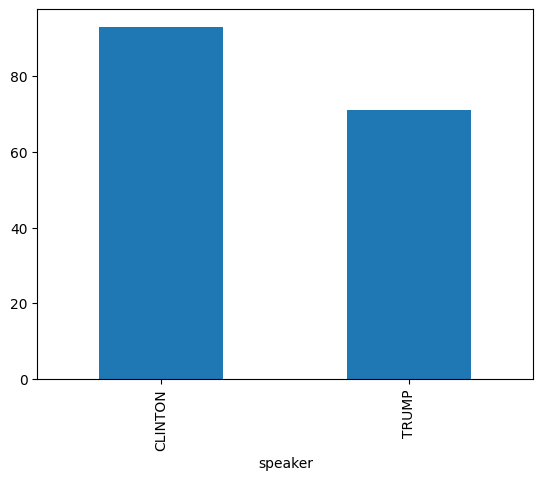

In [3]:
# Vérifier la distribution des auteurs
distribution = df['speaker'].value_counts()
print(distribution)
distribution.plot(kind='bar')


### 1.3 Création du corpus avec découpage en phrases


In [ ]:
# on fabrique un corpus en coupant les discours en phrases
corpus = Corpus("Corpus_Discours_US")

doc_id = 0
for _, row in df.iterrows():
    speaker = row['speaker']
    texte_original = str(row['text'])
    date_str = row['date']
    descr = row['descr']
    link = row['link']
    
    # petit découpage maison (., !, ?)
    phrases = re.split(r'[.!?]+', texte_original)
    
    for phrase in phrases:
        phrase = phrase.strip()
        # on zappe les miettes trop courtes
        if len(phrase) > 20:
            # titre rapide avec les premiers mots
            titre_phrase = phrase[:50] + "..." if len(phrase) > 50 else phrase
            
            # un Document par phrase
            doc = Document(
                titre=titre_phrase,
                auteur=speaker,
                date_str=date_str,
                url=link,
                texte=phrase
            )
            
            corpus.add_document_obj(doc_id, doc)
            doc_id += 1

print(f"Corpus créé: {corpus}")
print(f"Nombre total de phrases/document créés: {corpus.ndoc}")


Corpus créé: <Corpus 'Corpus_Discours_US', 29932 document(s), 2 auteur(s)>
Nombre total de phrases/document créés: 29932


### 1.4 Tests avec search et concorde


In [ ]:
# petit test de recherche rapide
mot_cle = "Ame"
resultats_search = corpus.search(mot_cle)
print(f"Nombre de documents trouvés pour '{mot_cle}': {len(resultats_search)}")
if resultats_search:
    for i, (doc_id, doc) in enumerate(resultats_search[:3]):
        print(f"{i+1}. Doc {doc_id}: {doc.titre[:60]}...")


Nombre de documents trouvés pour 'Ame': 3807
1. Doc 3: Americans have fought their way back from tough ec......
2. Doc 4: Everyday Americans need a champion and I want to b......
3. Doc 5: So you can do more than just get by, you can get a......


In [ ]:
# et un coup d'oeil sur la concordance
df_concorde = corpus.concorde(mot_cle, taille=30)
print(f"Nombre de concordances trouvées: {len(df_concorde)}")
if not df_concorde.empty:
    df_concorde.head(5)


Nombre de concordances trouvées: 0


## Partie 2 : Utilisation du moteur de recherche


### 2.1 Initialisation du moteur


In [ ]:
# on instancie le moteur (TF/TFIDF maison)
moteur = MoteurRecherche(corpus)


### 2.2 Tests avec plusieurs requêtes


In [10]:
# Tester avec plusieurs requêtes
requetes = ["America", "economy", "people", "country"]
for req in requetes:
    print(f"\nRecherche: '{req}'")
    resultats = moteur.search(req, nb_docs=3)
    if not resultats.empty:
        print(resultats[['titre', 'score']].to_string(index=False))
    else:
        print("Aucun résultat")



Recherche: 'America'


Calcul des scores: 100%|██████████| 29932/29932 [00:02<00:00, 12020.07it/s]


                                    titre    score
     I Am For America – and America First 0.742560
     I Am For America – and America First 0.742560
America is great, because America is good 0.680352

Recherche: 'economy'


Calcul des scores: 100%|██████████| 29932/29932 [00:02<00:00, 11748.25it/s]


                                                titre    score
                               What about our economy 0.715493
Well, you have to have a Treasury Secretary who un... 0.655397
                               Let's take the economy 0.583747

Recherche: 'people'


Calcul des scores: 100%|██████████| 29932/29932 [00:02<00:00, 11244.18it/s]


                                       titre    score
   But -- but people -- the people are great 0.593923
Working people and the great people of the U 0.497460
     Those are people those are great people 0.452643

Recherche: 'country'


Calcul des scores: 100%|██████████| 29932/29932 [00:02<00:00, 11246.72it/s]

                titre    score
They know the country 0.600545
To this great country 0.549138
Got to have a country 0.538082


## Partie 3 : Interface avec widgets


### 3.1-3.4 Création des widgets


In [ ]:
from ipywidgets import Label, Text, IntSlider, Button, VBox, HBox, Output
from IPython.display import display, clear_output

# petits widgets basiques pour jouer
titre = Label(value="Moteur de Recherche", style={'font_size': '20px', 'font_weight': 'bold'})
input_mots = Text(value="", placeholder="Entrez vos mots-clés", description="Mots-clés:")
slider_nb_docs = IntSlider(value=5, min=1, max=20, step=1, description="Nb docs:")

# la zone où on affiche les réponses
output = Output()

# le bouton qui lance tout
bouton = Button(description="Rechercher", button_style='info', icon='search')


### 3.5 Fonction de recherche


In [ ]:
# callback du bouton (rien de sorcier)
def clique_bouton(b):
    with output:
        clear_output(wait=True)
        mots = input_mots.value
        nb = slider_nb_docs.value
        
        if mots.strip():
            print(f"Recherche: '{mots}' ({nb} résultats)\n")
            resultats = moteur.search(mots, nb_docs=nb)
            
            if not resultats.empty:
                print(resultats.to_string(index=False))
            else:
                print("Aucun résultat trouvé.")
        else:
            print("Veuillez entrer des mots-clés.")

bouton.on_click(clique_bouton)


### 3.6 Affichage de l'interface


In [ ]:
# on assemble tout ça en colonne
interface = VBox([
    titre,
    HBox([input_mots, slider_nb_docs]),
    bouton,
    output
])

display(interface)


### 3.7 Interface avec filtres (optionnel)


In [ ]:
# version avec un filtre auteur (optionnel)
from ipywidgets import Dropdown

# liste d'auteurs dispo (et un "tous")
auteurs_dispo = sorted(corpus.authors.keys())
auteurs_dispo.insert(0, "Tous les auteurs")

# petit select pour l'auteur
filtre_auteur = Dropdown(
    options=auteurs_dispo,
    value="Tous les auteurs",
    description="Auteur:"
)

# bouton dédié à cette vue
bouton_avance = Button(description="Rechercher avec filtres", button_style='info', icon='search')

# recherche avec filtre auteur
def recherche_avec_filtres(b):
    with output:
        clear_output(wait=True)
        mots = input_mots.value
        nb = slider_nb_docs.value
        auteur_filtre = filtre_auteur.value
        
        if mots.strip():
            print(f"Recherche: '{mots}' ({nb} résultats)")
            if auteur_filtre != "Tous les auteurs":
                print(f"Filtre auteur: {auteur_filtre}\n")
            
            resultats = moteur.search(mots, nb_docs=nb)
            
            # on filtre après coup si besoin
            if auteur_filtre != "Tous les auteurs" and not resultats.empty:
                resultats = resultats[resultats['auteur'] == auteur_filtre]
            
            if not resultats.empty:
                print(resultats.to_string(index=False))
            else:
                print("Aucun résultat trouvé.")
        else:
            print("Veuillez entrer des mots-clés.")

bouton_avance.on_click(recherche_avec_filtres)

# mise en page de la vue filtrée
interface_avancee = VBox([
    Label(value="Moteur de Recherche avec Filtres", style={'font_size': '20px', 'font_weight': 'bold'}),
    HBox([input_mots, slider_nb_docs]),
    HBox([filtre_auteur]),
    bouton_avance,
    output
])

# pour l'afficher, décommentez si besoin
display(interface_avancee)
